In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Path to the final enriched database
CHRONICLE_DB_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\imerg_rain_outputs\chronicle_urban_df_with_IMERG_FULL.pkl"

# Load the DataFrame
df_chronicle = pd.read_pickle(CHRONICLE_DB_PATH)
df_chronicle.shape

(520426, 22)

In [2]:
# ============================================
# CONFIGURATION
# ============================================

# Define the durations (in minutes) for intensity calculation
# Base resolution is 30 min
DURATIONS = [30, 60, 120, 240, 360, 720, 1440]

print(f"Starting Intensity Analysis for {len(df_chronicle)} events...")

# List to store result dictionaries
results_list = []

# ============================================
# CALCULATION LOOP
# ============================================

for idx, row in tqdm(df_chronicle.iterrows(), total=len(df_chronicle)):
    
    # Extract Matrix and Mask
    matrix = row['imerg_matrix'] # Shape: (Time, Y, X)
    mask = row['imerg_mask']     # Shape: (Y, X)
    
    # --- VALIDATION ---
    # Skip if matrix is None or empty
    if not isinstance(matrix, np.ndarray) or matrix.size == 0:
        continue
        
    # Skip if mask has no valid pixels
    if mask.sum() == 0:
        continue

    # --- STEP 1: SPATIAL AVERAGE ---
    # Collapse spatial dimensions: (Time, Y, X) -> (Time,)
    # Select pixels where mask == 1 and take the mean across spatial dimensions
    # Result is a 1D array representing the basin-averaged hyetograph (mm/hr)
    valid_pixels = matrix[:, mask == 1]
    hyetograph_series = np.nanmean(valid_pixels, axis=1)
    
    # Convert to pandas Series for rolling window calculations
    ts_series = pd.Series(hyetograph_series)

    # Initialize result dictionary for this event
    event_stats = {'event_id': row['event_id']}
    
    # --- STEP 2: TEMPORAL ROLLING MAX ---
    for minutes in DURATIONS:
        # Calculate window size in time steps (IMERG is 30 min resolution)
        # e.g., 60 min duration = 2 steps
        window_size = int(minutes / 30)
        
        # Check if the time series is long enough for this window
        if len(ts_series) >= window_size:
            # Calculate rolling MEAN to get intensity (mm/hr) over the window
            # Then take the MAX value to find peak intensity
            max_intensity = ts_series.rolling(window=window_size).mean().max()
        else:
            max_intensity = np.nan # Time series too short for this duration
            
        # Add to dictionary: e.g., '60_max_rainfall_intens'
        col_name = f"{minutes}_max_rainfall_intens"
        event_stats[col_name] = max_intensity
        
    results_list.append(event_stats)

# ============================================
# MERGE RESULTS
# ============================================

# Convert results to DataFrame
df_intensities = pd.DataFrame(results_list)

print(f"Calculated intensities for {len(df_intensities)} events.")

# Merge back to the main dataframe
# We use 'left' join to keep all original rows, filling NaNs where calculation failed
df_chronicle_intensities = df_chronicle.merge(df_intensities, on='event_id', how='left')

# Display sample of the new columns
cols_to_show = ['event_id'] + [f"{d}_max_rainfall_intens" for d in DURATIONS]
print("\n--- Sample Results (df_chronicle_intensities) ---")
print(df_chronicle_intensities[cols_to_show].head())

Starting Intensity Analysis for 520426 events...


100%|████████████████████████████████████████████████████████████████████████| 520426/520426 [05:49<00:00, 1489.60it/s]


Calculated intensities for 520147 events.

--- Sample Results (df_chronicle_intensities) ---
   event_id  30_max_rainfall_intens  60_max_rainfall_intens  \
0       296                4.568446                4.568446   
1       297                5.905882                5.328168   
2       298                1.239642                0.898038   
3       299                5.905882                5.328168   
4       300               20.037289               15.327168   

   120_max_rainfall_intens  240_max_rainfall_intens  360_max_rainfall_intens  \
0                 3.679287                 2.567239                 1.828248   
1                 4.617779                 3.525245                 2.631945   
2                 0.698607                 0.636494                 0.466378   
3                 4.617779                 3.525245                 2.631945   
4                 9.840519                 4.920259                 3.280173   

   720_max_rainfall_intens  1440_max_rainfall_i

In [3]:
df_chronicle_intensities.columns

Index(['Unnamed: 0', 'uuid', 'area_km2', 'version', 'start_time', 'end_time',
       'duration_days', 'geometry_wkt', 'urban_built_up_area_m2',
       'polygon_total_area_m2', 'urban_percentage', 'event_id',
       'poly_area_km2', 'upa_max', 'upa_p95', 'upa_p99', 'PFDI_p95',
       'PFDI_p99', 'PFDI_max', 'imerg_matrix', 'imerg_mask', 'imerg_meta',
       '30_max_rainfall_intens', '60_max_rainfall_intens',
       '120_max_rainfall_intens', '240_max_rainfall_intens',
       '360_max_rainfall_intens', '720_max_rainfall_intens',
       '1440_max_rainfall_intens'],
      dtype='object')

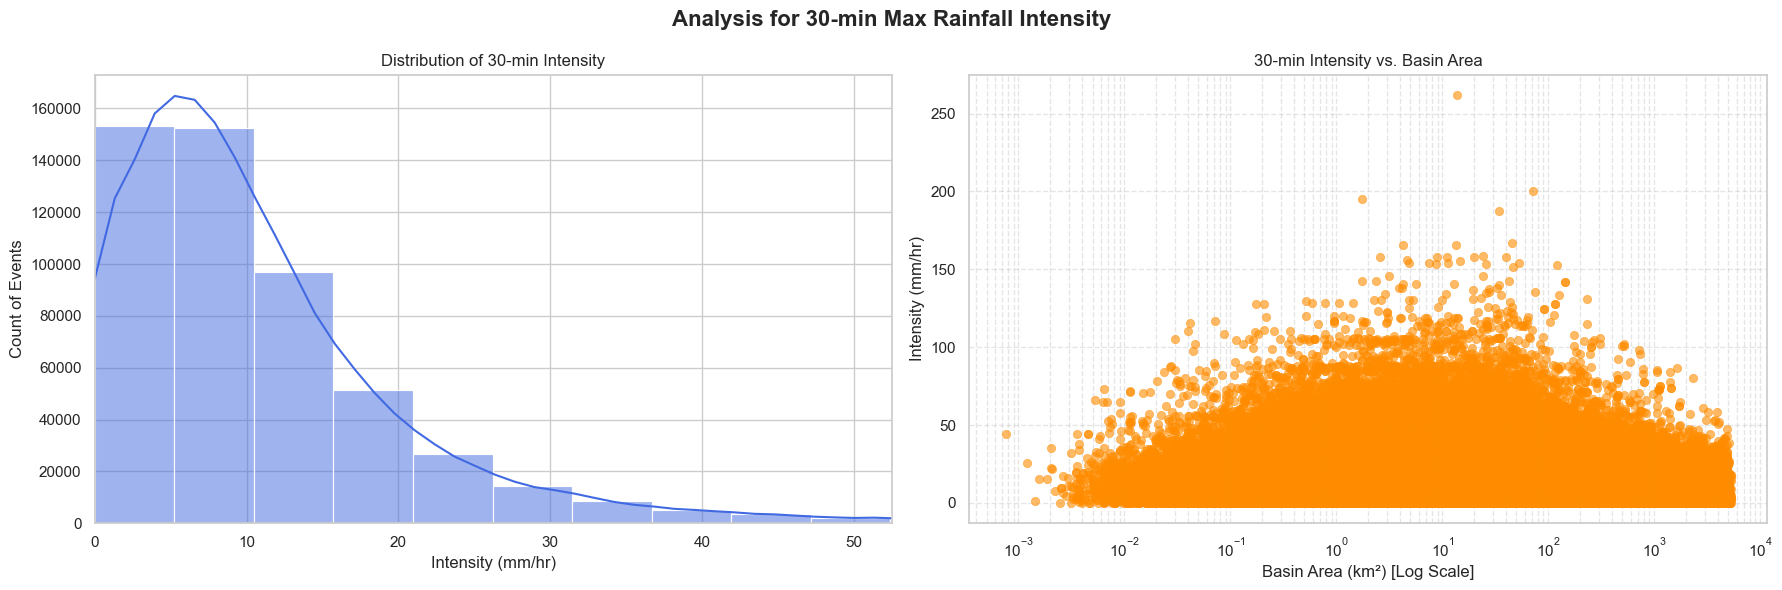

--------------------------------------------------------------------------------


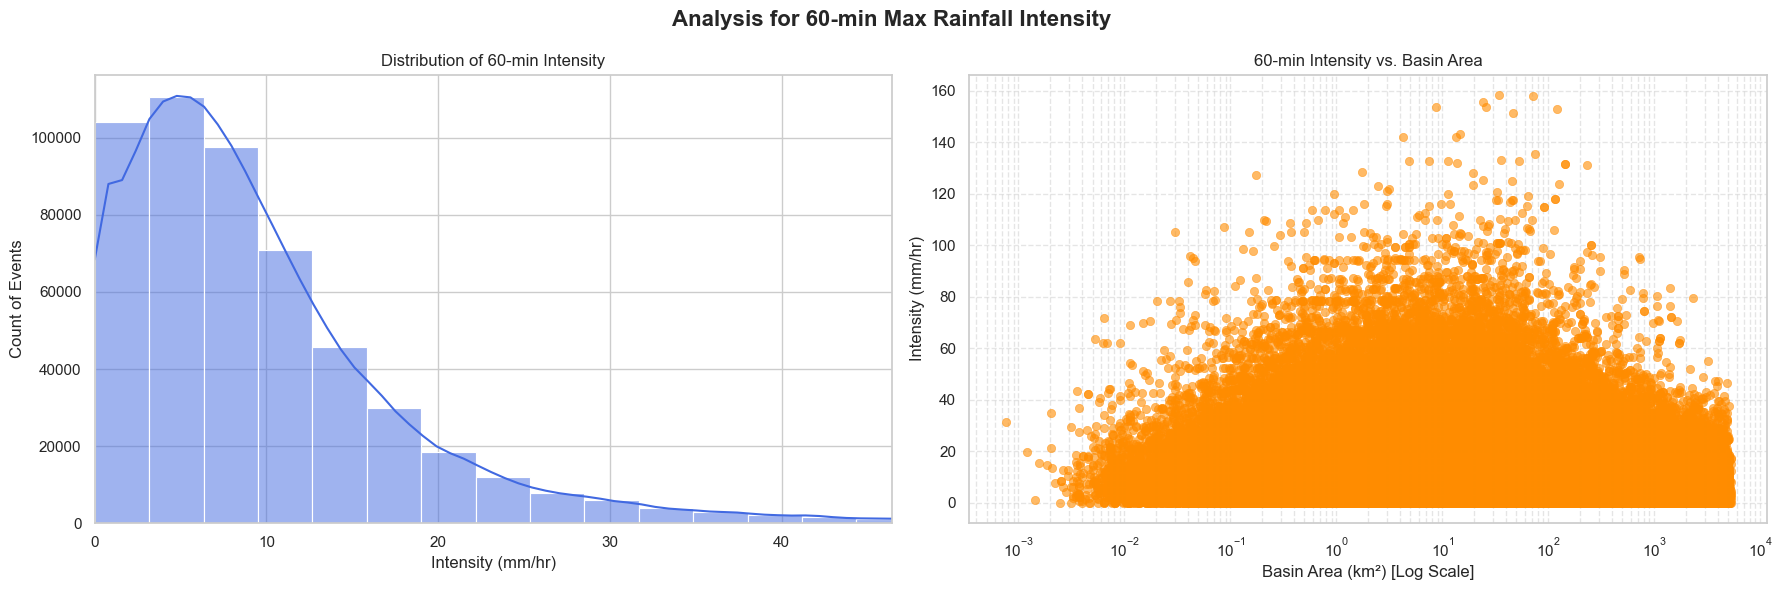

--------------------------------------------------------------------------------


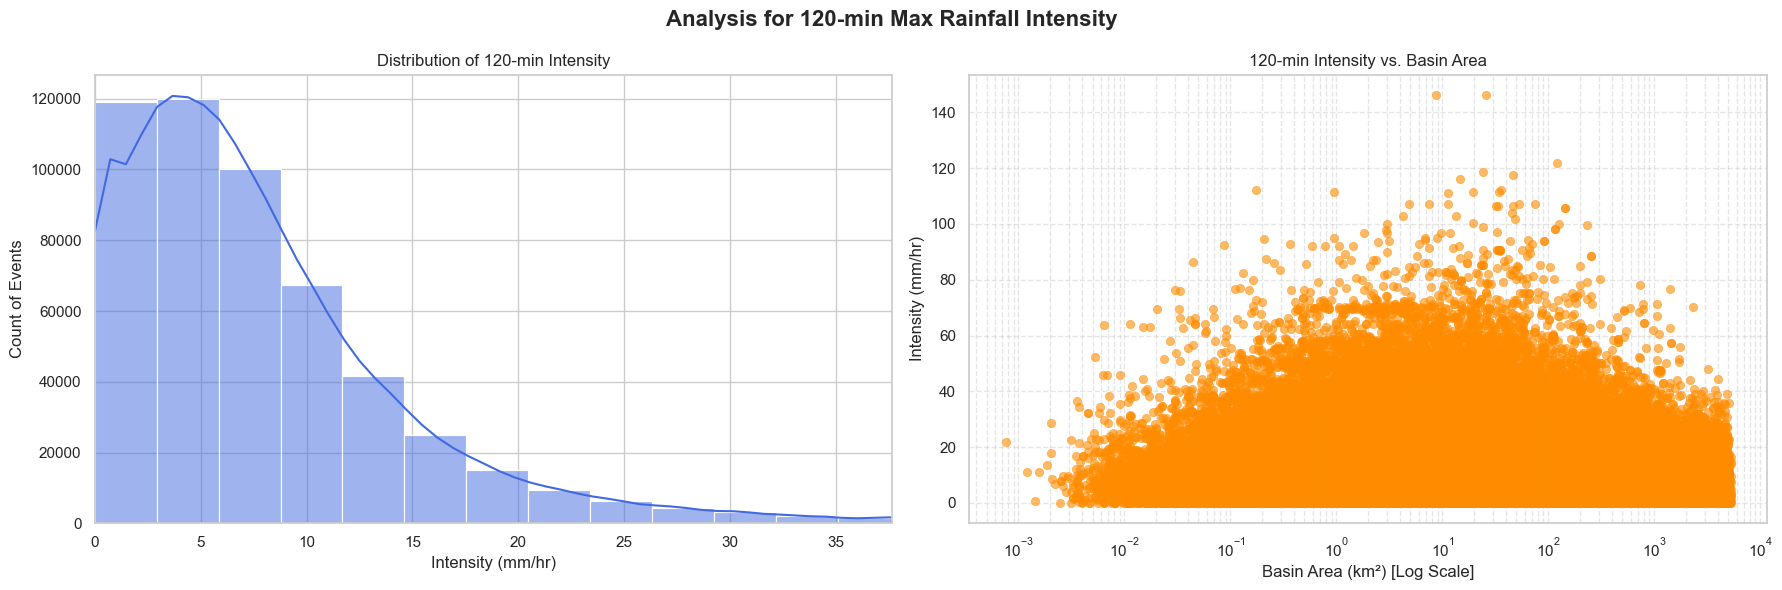

--------------------------------------------------------------------------------


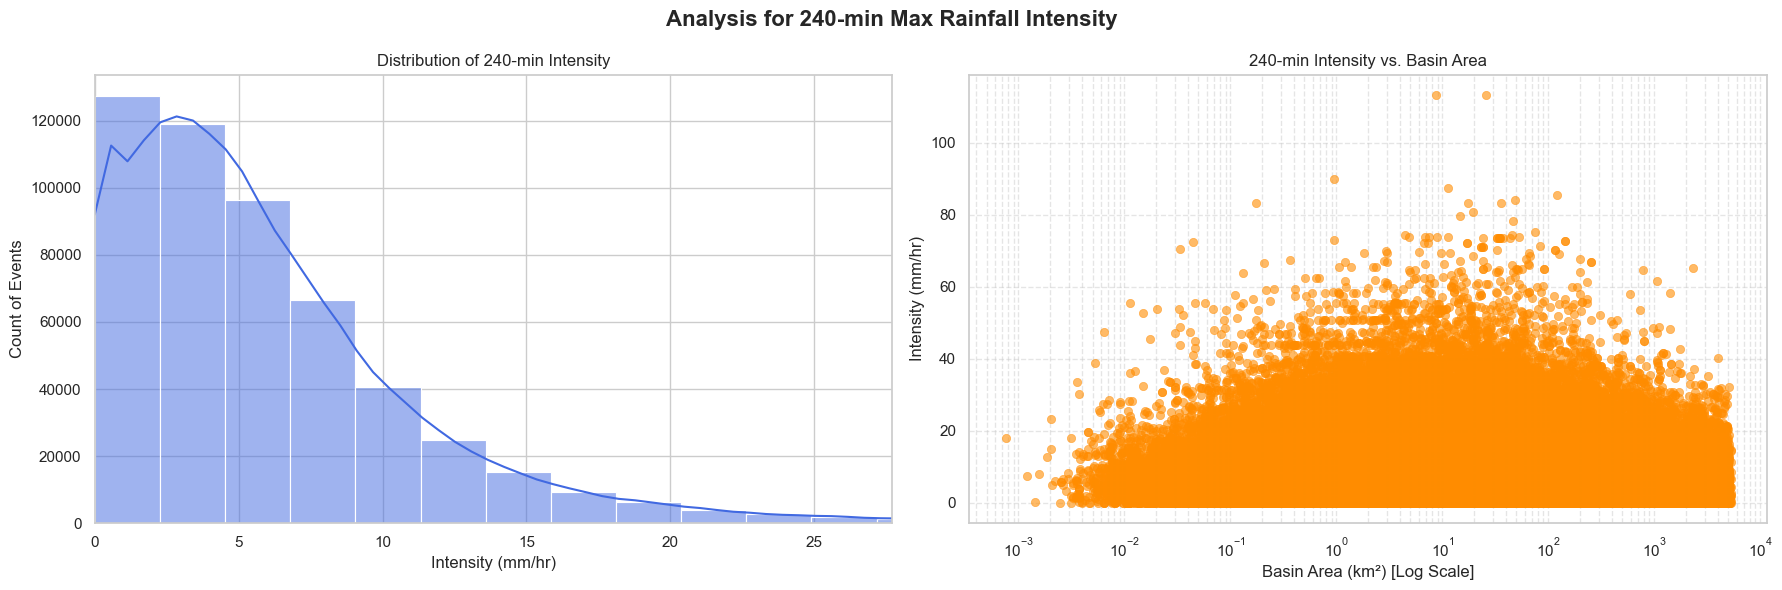

--------------------------------------------------------------------------------


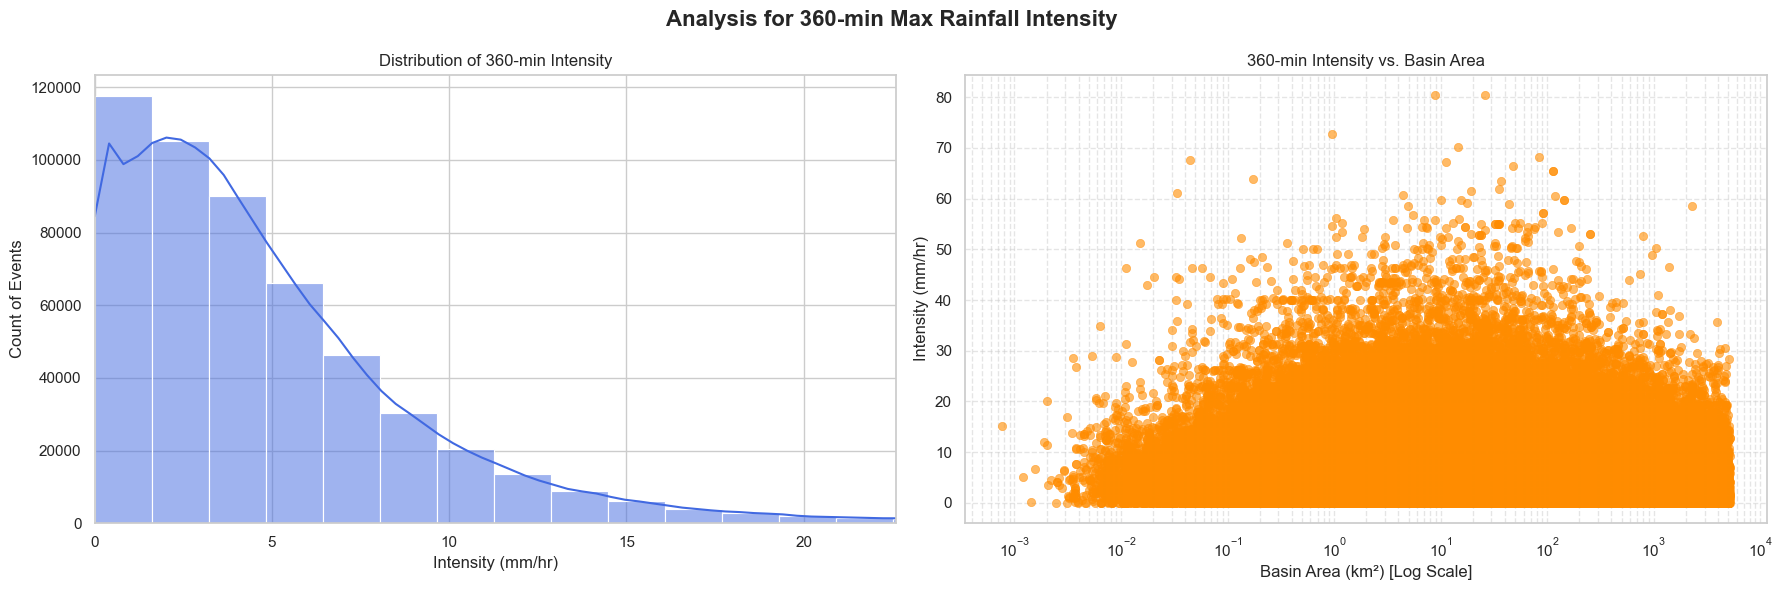

--------------------------------------------------------------------------------


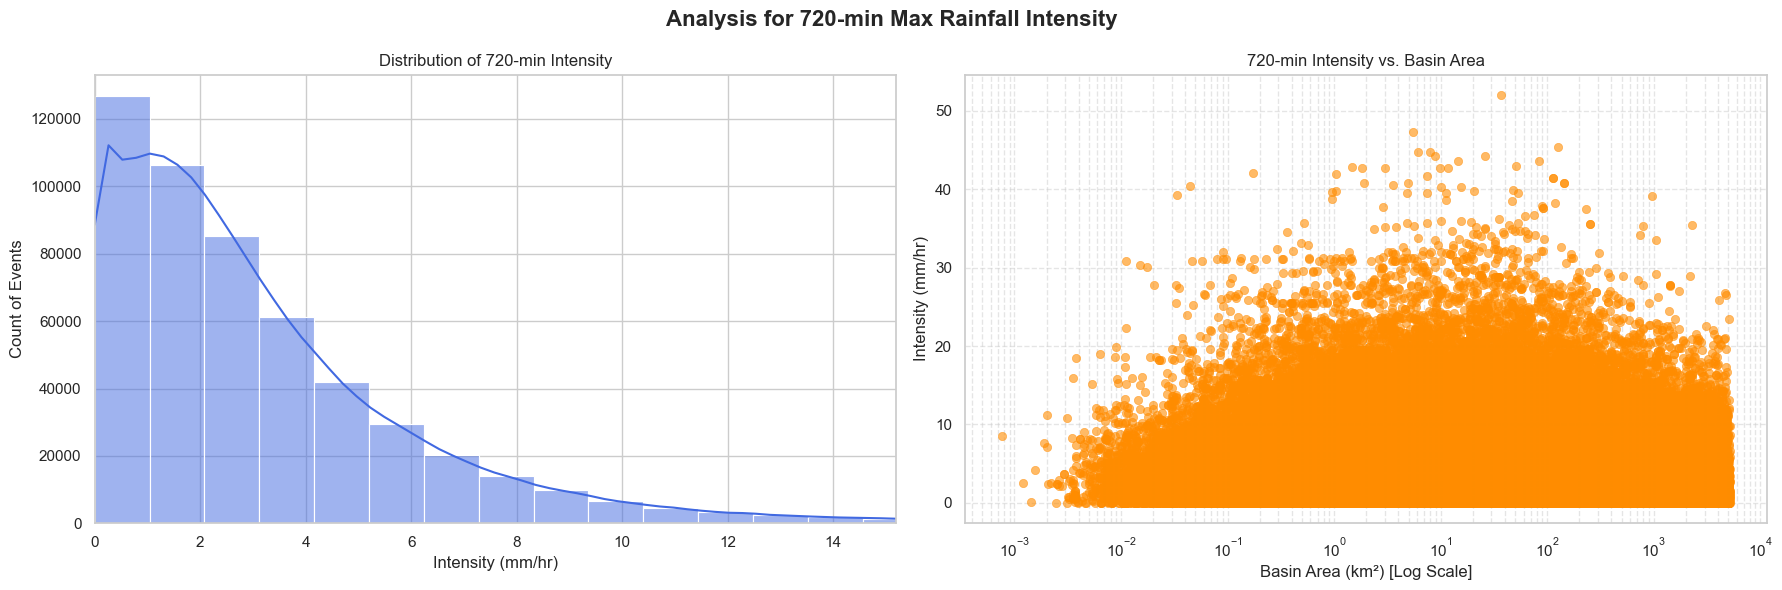

--------------------------------------------------------------------------------


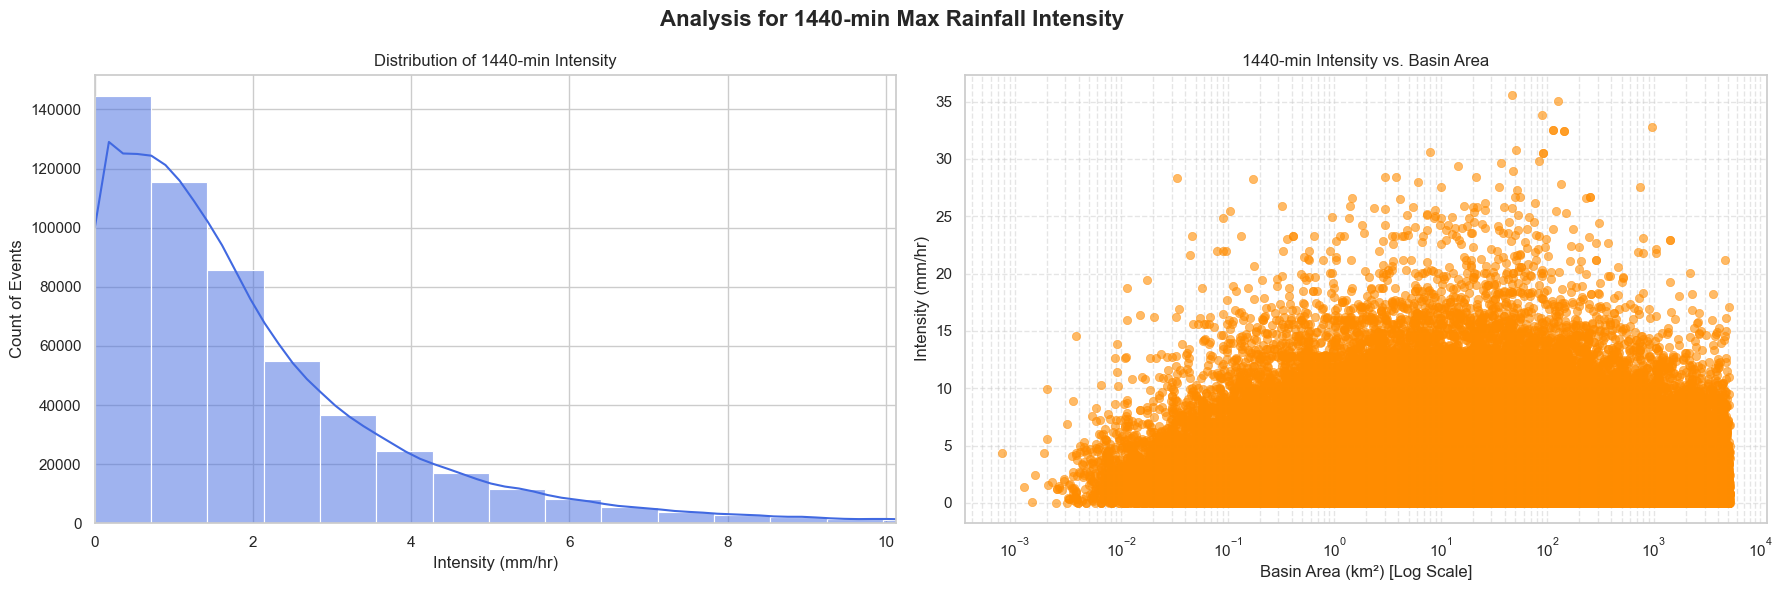

--------------------------------------------------------------------------------


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================
# CONFIGURATION
# ============================================
# Set global plot style
sns.set_theme(style="whitegrid")

# ============================================
# VISUALIZATION LOOP
# ============================================

for duration in DURATIONS:
    
    # Construct the column name dynamically
    col_name = f"{duration}_max_rainfall_intens"
    
    # Check if column exists (safety check)
    if col_name not in df_chronicle_intensities.columns:
        print(f"Skipping {duration} min: Column {col_name} not found.")
        continue
        
    # Create a figure with 2 subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Title for the entire figure
    fig.suptitle(f"Analysis for {duration}-min Max Rainfall Intensity", fontsize=16, fontweight='bold')
    
    # --- Plot 1: Distribution (Histogram + KDE) ---
    sns.histplot(
        data=df_chronicle_intensities,
        x=col_name,
        bins=50,
        kde=True,
        color='royalblue',
        ax=axes[0]
    )
    
    axes[0].set_title(f"Distribution of {duration}-min Intensity")
    axes[0].set_xlabel("Intensity (mm/hr)")
    axes[0].set_ylabel("Count of Events")
    
    # Limit x-axis to 99th percentile to hide extreme outliers
    upper_limit = df_chronicle_intensities[col_name].quantile(0.99)
    if not np.isnan(upper_limit):
        axes[0].set_xlim(0, upper_limit)
    
    # --- Plot 2: Intensity vs. Basin Area ---
    sns.scatterplot(
        data=df_chronicle_intensities, 
        x='poly_area_km2', 
        y=col_name, 
        alpha=0.6, 
        edgecolor=None,
        ax=axes[1],
        color='darkorange'
    )
    
    # Use Log Scale for X-axis (Area)
    axes[1].set_xscale('log')
    
    axes[1].set_title(f"{duration}-min Intensity vs. Basin Area")
    axes[1].set_xlabel("Basin Area (km²) [Log Scale]")
    axes[1].set_ylabel("Intensity (mm/hr)")
    axes[1].grid(True, which="both", ls="--", alpha=0.5)
    
    # Final layout adjustments
    plt.tight_layout()
    plt.show()

    print("-" * 80) # Separator line between durations

Descriptive Statistics for Rainfall Intensities:
       30_max_rainfall_intens  60_max_rainfall_intens  \
count           520147.000000           520147.000000   
mean                11.357323                9.980763   
std                 10.714838                9.458598   
min                  0.000000                0.000000   
25%                  4.509689                3.922573   
50%                  8.734993                7.714651   
75%                 14.824439               13.062580   
max                262.005951              158.389221   

       120_max_rainfall_intens  240_max_rainfall_intens  \
count            520147.000000            520147.000000   
mean                  8.209642                 6.171955   
std                   7.725230                 5.779195   
min                   0.000000                 0.000000   
25%                   3.190248                 2.313546   
50%                   6.391700                 4.806214   
75%                  10.

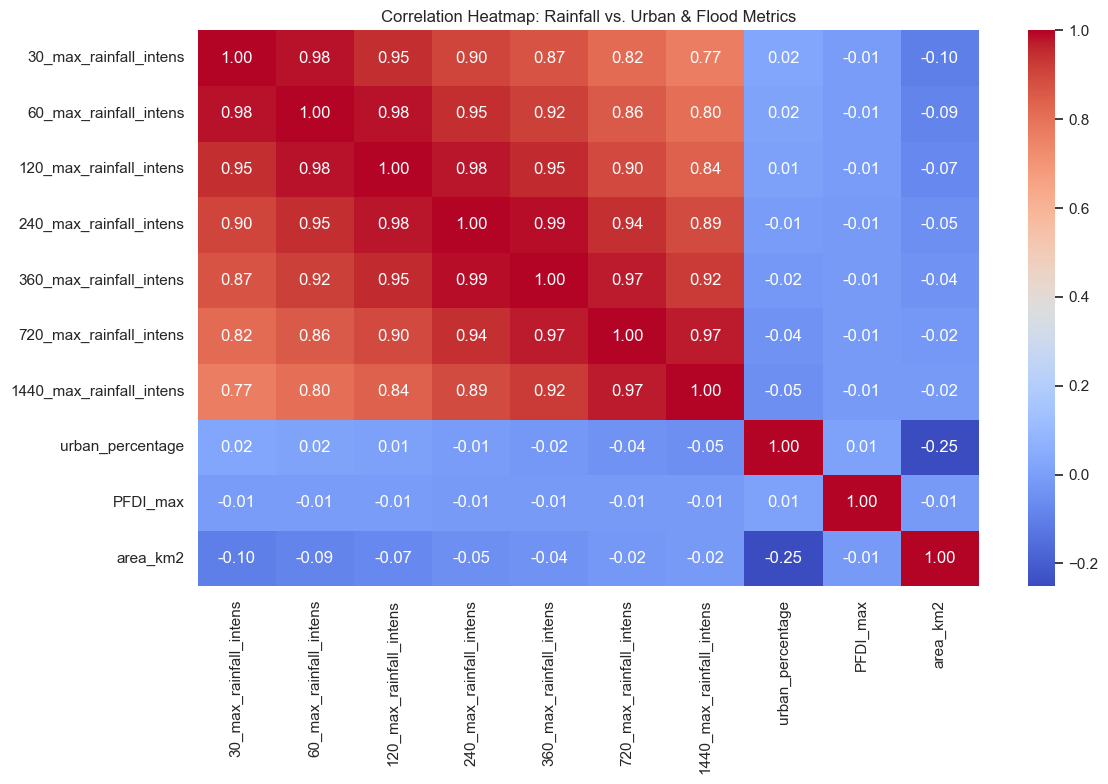

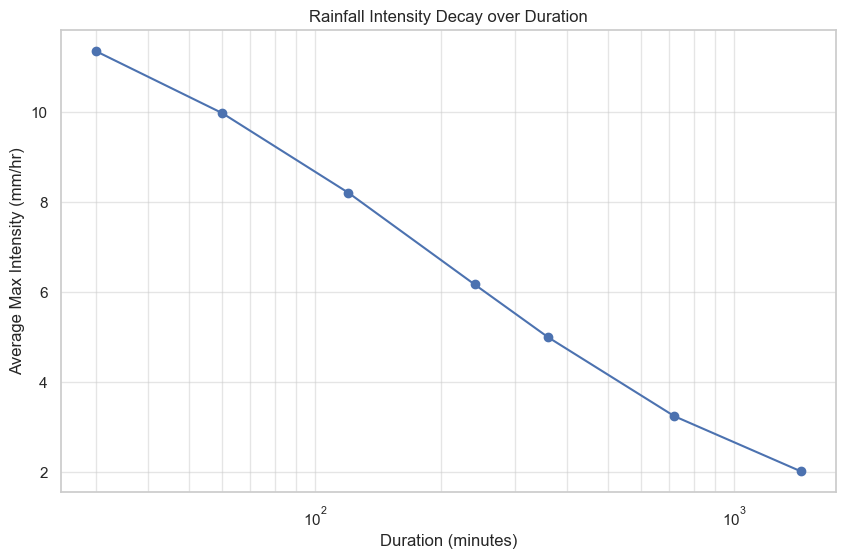

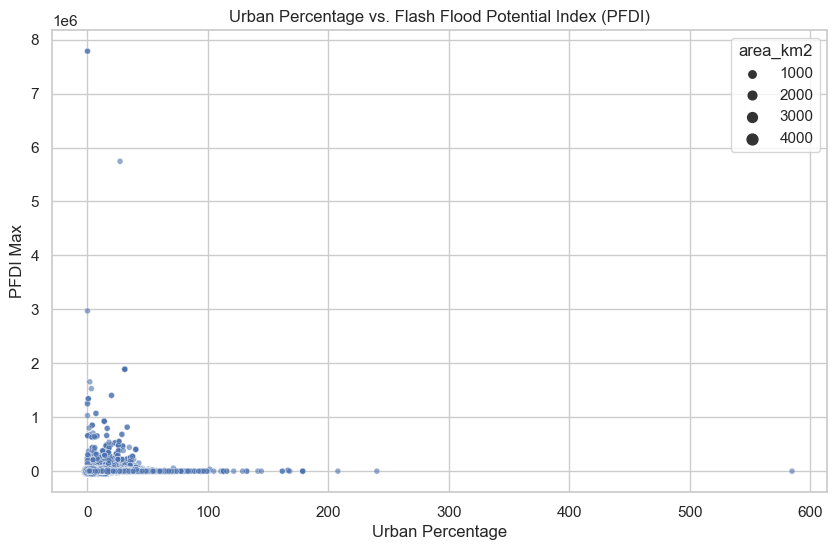


Top 10 Extreme Events (by 60-min intensity):
                                    uuid start_time  60_max_rainfall_intens  \
52196   1e1b360efe1c40d58fc82e5c2e6d9288 2011-11-07              158.389221   
101782  ab11eda52cc64c57ad079cbd222d0b2e 2014-05-15              158.070656   
38011   00347903ea7d469a8e27416cfba98c48 2010-10-17              155.596870   
52249   d93fdcdb931d41e2ad561aaca28e2b65 2011-11-07              153.523392   
52327   686211df3cc743b98bc409dacf888875 2011-11-09              153.523392   
2007    1aa13874157f40ad9f675fed769055be 2001-09-17              152.900818   
23161   87dfefc291ad4c3993ed21be14b215fc 2009-08-09              151.247078   
22968   c72728330b30433cada2181f92fbd3c9 2009-08-06              143.286301   
52216   24fe378ece0444bca023814dc6e97cf1 2011-11-07              141.938072   
52252   e4749c682cbe4a9e939a1b9fa02c4f33 2011-11-07              141.938072   

        urban_percentage     PFDI_max  
52196           2.349910   154.570222  
1017

C:\Users\raznu\Anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


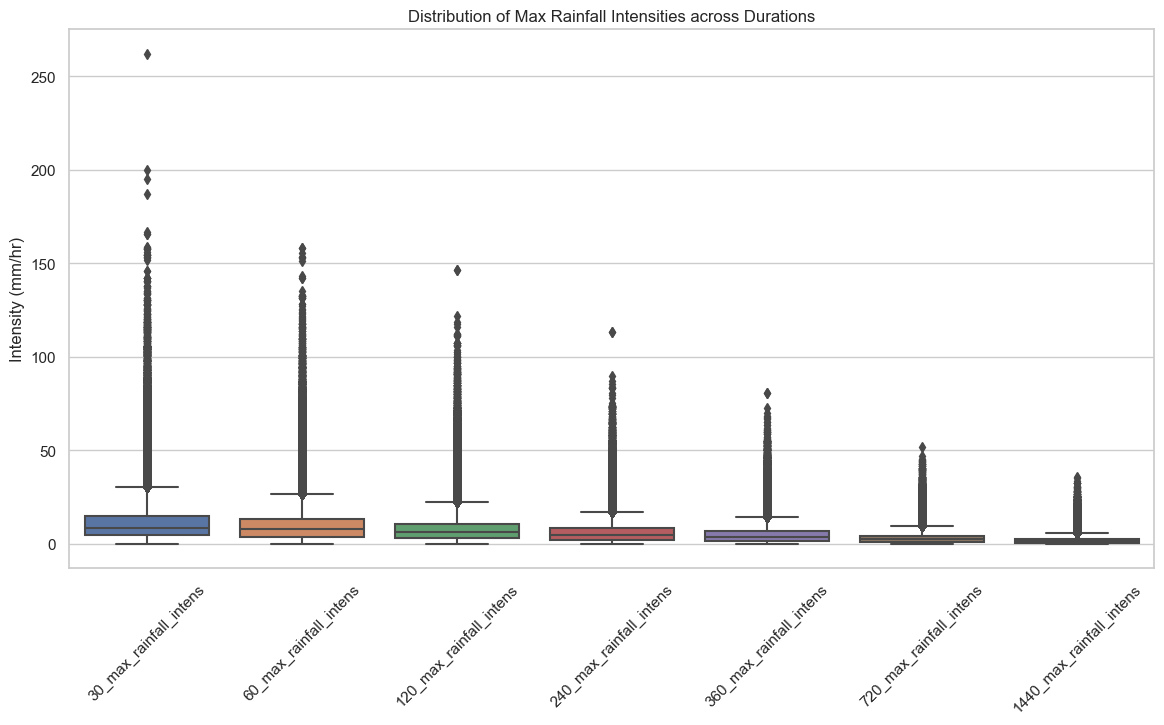

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_chronicle_intensities is already defined in your environment

# 1. Define the rainfall intensity columns for easier access
intensity_cols = [
    '30_max_rainfall_intens', '60_max_rainfall_intens', 
    '120_max_rainfall_intens', '240_max_rainfall_intens', 
    '360_max_rainfall_intens', '720_max_rainfall_intens', 
    '1440_max_rainfall_intens'
]

# 2. Basic Descriptive Statistics
# Understanding the distribution of rainfall intensities across different durations
print("Descriptive Statistics for Rainfall Intensities:")
print(df_chronicle_intensities[intensity_cols].describe())

# 3. Correlation Analysis
# Checking relationships between rainfall, urban percentage, and flood indices
cols_to_corr = intensity_cols + ['urban_percentage', 'PFDI_max', 'area_km2']
corr_matrix = df_chronicle_intensities[cols_to_corr].corr()

# Visualize Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Rainfall vs. Urban & Flood Metrics')
plt.tight_layout()
plt.show()

# 4. Rainfall Decay Curve (Mean Intensity vs Duration)
# Transforming the columns to extract the duration as a numeric value
durations = [30, 60, 120, 240, 360, 720, 1440]
mean_intensities = df_chronicle_intensities[intensity_cols].mean()

plt.figure(figsize=(10, 6))
plt.plot(durations, mean_intensities, marker='o', linestyle='-', color='b')
plt.xscale('log') # Log scale is common for duration
plt.xlabel('Duration (minutes)')
plt.ylabel('Average Max Intensity (mm/hr)')
plt.title('Rainfall Intensity Decay over Duration')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# 5. Urban Impact Visualization
# Scatter plot to see if higher urban percentage correlates with higher PFDI_max
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_chronicle_intensities, x='urban_percentage', y='PFDI_max', size='area_km2', alpha=0.6)
plt.title('Urban Percentage vs. Flash Flood Potential Index (PFDI)')
plt.xlabel('Urban Percentage')
plt.ylabel('PFDI Max')
plt.show()

# 6. Identifying Top Extreme Events
# Ranking events by their 60-minute peak intensity
top_events = df_chronicle_intensities.sort_values(by='60_max_rainfall_intens', ascending=False).head(10)
print("\nTop 10 Extreme Events (by 60-min intensity):")
print(top_events[['uuid', 'start_time', '60_max_rainfall_intens', 'urban_percentage', 'PFDI_max']])

# 7. Distribution of Intensities
# Boxplot to see outliers and spread across durations
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_chronicle_intensities[intensity_cols])
plt.xticks(rotation=45)
plt.title('Distribution of Max Rainfall Intensities across Durations')
plt.ylabel('Intensity (mm/hr)')
plt.show()

In [6]:
STOP!

SyntaxError: invalid syntax (2635050600.py, line 1)

In [ ]:
# ============================================
# ANALYSIS NOTEBOOK
# ============================================

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Settings
INPUT_DIR = r"D:\Development\RESEARCH\urban_flood_database\chronicle\imerg_rain_outputs"

In [ ]:
# ============================================
# 1. LOAD DATA (FROM BATCHES)
# ============================================
def load_all_batches(directory):
    pattern = os.path.join(directory, "imerg_batch_*.pkl")
    files = glob.glob(pattern)
    
    if not files:
        print("No data found!")
        return pd.DataFrame()
        
    print(f"Loading {len(files)} batch files...")
    df_list = []
    for f in tqdm(files):
        try:
            df_list.append(pd.read_pickle(f))
        except Exception as e:
            print(f"Skipped {f}: {e}")
            
    return pd.concat(df_list, ignore_index=True)

# Load
df = load_all_batches(INPUT_DIR)

# Filter valid rain data
df_rain = df.dropna(subset=['imerg_matrix']).copy()
print(f"Loaded {len(df_rain)} events with rain data.")

In [ ]:
df_rain['imerg_matrix']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# --- Plot 1: Distribution of Max Intensity ---
plt.figure(figsize=(10, 6))

# Plot histogram with a Kernel Density Estimate (KDE) line
sns.histplot(df_analysis['max_intensity_mm_hr'], bins=50, kde=True, color='blue')

plt.title("Distribution of Max 30-min Rain Intensity (Basin Averaged)")
plt.xlabel("Max Intensity (mm/hr)")
plt.ylabel("Count of Events")

# Limit x-axis to 99th percentile to hide extreme outliers and make the plot readable
upper_limit = df_analysis['max_intensity_mm_hr'].quantile(0.99)
plt.xlim(0, upper_limit)

plt.tight_layout()
plt.show()

# --- Plot 2: Max Intensity vs. Basin Area ---
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(
    data=df_analysis, 
    x='poly_area_km2', 
    y='max_intensity_mm_hr', 
    alpha=0.6, 
    edgecolor=None
)

# Use Log Scale for X-axis (Area spans multiple orders of magnitude)
plt.xscale('log')

plt.title("Max Rain Intensity vs. Basin Area")
plt.xlabel("Basin Area (km²) [Log Scale]")
plt.ylabel("Max Intensity (mm/hr)")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# 2. FEATURE EXTRACTION (The Important Part)
# ============================================
# Raw matrices are hard to analyze. Let's convert them to single numbers (Scalars).

stats_list = []

print("Extracting rain features...")
for idx, row in tqdm(df_rain.iterrows(), total=len(df_rain)):
    
    matrix = row['imerg_matrix'] # Shape: (Time, Y, X)
    mask = row['imerg_mask']     # Shape: (Y, X)
    
    # Safety check for empty or broken arrays
    if not isinstance(matrix, np.ndarray) or matrix.size == 0:
        continue

    # A. BASIN AVERAGE HYETOGRAPH (Time Series)
    # We only care about pixels INSIDE the basin (mask == 1)
    # Boolean indexing allows us to select only relevant pixels across all time steps
    # matrix[:, mask==1] -> Shape becomes (Time Steps, N_Pixels)
    basin_pixels_over_time = matrix[:, mask == 1]
    
    if basin_pixels_over_time.size == 0:
        # Mask might be empty (no pixels center in polygon)
        avg_hyetograph = np.zeros(matrix.shape[0])
        max_hyetograph = np.zeros(matrix.shape[0])
    else:
        avg_hyetograph = np.nanmean(basin_pixels_over_time, axis=1) # Average rain per hour
        max_hyetograph = np.nanmax(basin_pixels_over_time, axis=1)  # Max rain per hour (peak intensity)

    # B. CALCULATE SCALAR METRICS
    features = {
        'event_id': row['event_id'],
        
        # Volume Metrics
        'rain_total_accum_mean': np.sum(avg_hyetograph), # Total rain depth (mm)
        'rain_max_hourly_intensity': np.max(avg_hyetograph), # Peak intensity (mm/hr)
        
        # Time Metrics
        # Find duration where rain > 0.1 mm/hr
        'rain_duration_hours': np.sum(avg_hyetograph > 0.1) * 0.5, # Assuming 30min steps
        
        # Spatial Metrics
        # Max rain recorded in ANY single pixel during the WHOLE event
        'rain_peak_single_pixel': np.max(matrix) if matrix.size > 0 else 0
    }
    
    stats_list.append(features)

# Create a clean Stats DataFrame
df_stats = pd.DataFrame(stats_list)

# Merge back with original metadata (like PFDI) if needed
# Assuming 'PFDI' is in the loaded pkl, if not, you merge with original dataset
if 'PFDI' in df_rain.columns:
    df_stats = df_stats.merge(df_rain[['event_id', 'PFDI', 'poly_area_km2']], on='event_id')

print("\n--- FEATURES READY ---")
print(df_stats.head())

# ============================================
# 3. ANALYSIS & PLOTS
# ============================================

# A. Histogram of Rain Depth
plt.figure(figsize=(10, 5))
sns.histplot(df_stats['rain_total_accum_mean'], bins=50, kde=True)
plt.title("Distribution of Total Rainfall Depth (Mean over Basin)")
plt.xlabel("Total Rain (mm)")
plt.show()

# B. The Golden Question: Rain vs. Flood (PFDI)
if 'PFDI' in df_stats.columns:
    plt.figure(figsize=(10, 6))
    
    # Use log scale because floods vary wildly
    sns.scatterplot(data=df_stats, x='rain_total_accum_mean', y='PFDI', alpha=0.6)
    
    plt.title("Correlation: Total Rain vs. Flood Intensity (PFDI)")
    plt.xlabel("Total Rain (mm)")
    plt.ylabel("PFDI (Flood Magnitude)")
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()
    
    # Simple Correlation
    corr = df_stats[['rain_total_accum_mean', 'rain_max_hourly_intensity', 'PFDI']].corr()
    print("Correlation Matrix:")
    print(corr)